This notebook will be purely focusing on the modeling part. I will start off by installing the GPU variant of TensorFlow 2.0 (Colab gives you T4 Tesla GPUs for free). 

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

I have the data serialized already. So, I would just load them and remove the index column which is a result of my inattentiveness. 

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
valid = pd.read_csv('data/valid.csv')
test = pd.read_csv('data/test.csv')

In [ ]:
train.drop('Unnamed: 0', axis='columns', inplace=True)
valid.drop('Unnamed: 0', axis='columns', inplace=True)
test.drop('Unnamed: 0', axis='columns', inplace=True)

In [74]:
train.columns

Index(['source', 'title'], dtype='object')

In [76]:
train.source.value_counts()

blogspot      33109
github        29287
techcrunch    24644
nytimes       23030
Name: source, dtype: int64

I like to define the constants and their values which would be used throughout the modeling process at the very beginning. Here, I will define:
- A mapping for encoding the sources to integers (computers understand numbers)
- Total size of the vocabulary that would be formed from the titles
- The maximum sequence length which would be needed for the preprocessing steps

In [ ]:
# Label encode
CLASSES = {'blogspot': 0, 'github': 1, 'techcrunch': 2, 'nytimes': 3} 
# Maximum vocabulary size used for tokenization
TOP_K = 20000 
# Sentences will be truncated/padded to this length
MAX_SEQUENCE_LENGTH = 50  

Next I would define a small helper function which would take a DataFrame and will 
- prepare a list of titles from the DstaFrame
- take the sources from the DataFrame, map them to integers and append to a NumPy array

In [ ]:
def return_data(df):
  return list(df['title']), np.array(df['source'].map(CLASSES))

In [ ]:
# Apply it to the three splits
train_text, train_labels = return_data(train)
valid_text, valid_labels = return_data(valid)
test_text, test_labels = return_data(test)

In [88]:
train_text[0], train_labels[0]

('nerds love twitch because there  they can be heroes', 2)

In [ ]:
# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D

In [ ]:
# Create a vocabulary from training corpus
tokenizer = text.Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(train_text)

In [ ]:
# Save token dictionary to use during inference
import pickle 

pickle.dump(tokenizer, open('tokenizer.pickled', 'wb'))

I am going to the `GloVe` embeddings to represent the words in the titles to a dense representation. The embeddings are of more than 650 MB and the GCP team has it stored in a Google Storage Bucket. This is going to be incredibly helpful since it will allow me to directly use it at a very fast speed. 

In [98]:
!gsutil cp gs://cloud-training-demos/courses/machine_learning/deepdive/09_sequence/text_classification/glove.6B.200d.txt glove.6B.200d.txt

Copying gs://cloud-training-demos/courses/machine_learning/deepdive/09_sequence/text_classification/glove.6B.200d.txt...
| [1 files][661.3 MiB/661.3 MiB]                                                
Operation completed over 1 objects/661.3 MiB.                                    


I will now define a helper function which will map the words in the titles with respect to the Glove embeddings. In literature this is often referred to as _embedding matrix_. 

In [ ]:
def get_embedding_matrix(word_index, embedding_path, embedding_dim):
  embedding_matrix_all = {}
  with open(embedding_path) as f:
    for line in f:  # Every line contains word followed by the vector value
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_matrix_all[word] = coefs

  # Prepare embedding matrix with just the words in our word_index dictionary
  num_words = min(len(word_index) + 1, TOP_K)
  embedding_matrix = np.zeros((num_words, embedding_dim))

  for word, i in word_index.items():
    if i >= TOP_K:
        continue
    embedding_vector = embedding_matrix_all.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
  
  return embedding_matrix

Let's now define the hyperparameters for the network and also define the constants. 

In [ ]:
filters=64
dropout_rate=0.2
embedding_dim=200
kernel_size=3
pool_size=3

In [ ]:
word_index=tokenizer.word_index
embedding_path = '/content/glove.6B.200d.txt'
embedding_dim=200

### Model building

In [ ]:
# Create model instance
model = models.Sequential()
num_features = min(len(word_index) + 1, TOP_K)

# Add embedding layer - GloVe embeddings
model.add(Embedding(input_dim=num_features,
              output_dim=embedding_dim,
              input_length=MAX_SEQUENCE_LENGTH,
              weights=[get_embedding_matrix(word_index, 
                              embedding_path, embedding_dim)],
              trainable=True))

model.add(Dropout(rate=dropout_rate))
model.add(Conv1D(filters=filters,
              kernel_size=kernel_size,
              activation='relu',
              bias_initializer='he_normal',
              padding='same'))

model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(filters=filters * 2,
              kernel_size=kernel_size,
              activation='relu',
              bias_initializer='he_normal',
              padding='same'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(rate=dropout_rate))
model.add(Dense(len(CLASSES), activation='softmax'))

# Compile model with learning parameters.
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

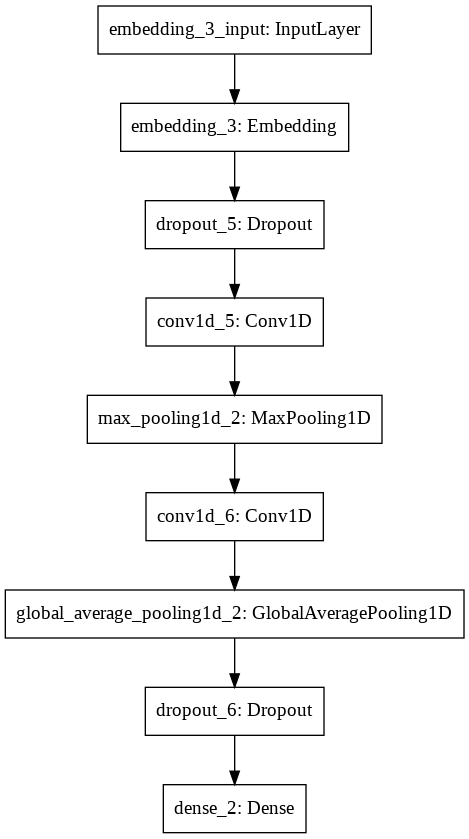

In [144]:
tf.keras.utils.plot_model(model, to_file='cnn_txt_cls.png')

### Data preprocessing: Tokenize + Pad

In [ ]:
# Preprocess the train, validation and test sets
# Tokenize and pad sentences
tokenizer = pickle.load( open( "tokenizer.pickled", "rb" ) )

preproc_train = tokenizer.texts_to_sequences(train_text)
preproc_train = sequence.pad_sequences(preproc_train, maxlen=MAX_SEQUENCE_LENGTH)

preproc_valid = tokenizer.texts_to_sequences(valid_text)
preproc_valid = sequence.pad_sequences(preproc_valid, maxlen=MAX_SEQUENCE_LENGTH)

preproc_test = tokenizer.texts_to_sequences(test_text)
preproc_test = sequence.pad_sequences(preproc_test, maxlen=MAX_SEQUENCE_LENGTH)

### Model training

In [149]:
H = model.fit(preproc_train,
         train_labels,
         validation_data=(preproc_valid, valid_labels),
         batch_size=128,
         epochs=10,
         verbose=1)

Train on 110070 samples, validate on 13759 samples
Epoch 1/10
110070/110070 [==============================] - 11s 104us/sample - loss: 0.8801 - acc: 0.6222 - val_loss: 0.7268 - val_acc: 0.7067
Epoch 2/10
110070/110070 [==============================] - 11s 99us/sample - loss: 0.6289 - acc: 0.7515 - val_loss: 0.7007 - val_acc: 0.7192
Epoch 3/10
110070/110070 [==============================] - 11s 99us/sample - loss: 0.5289 - acc: 0.7946 - val_loss: 0.7149 - val_acc: 0.7204
Epoch 4/10
110070/110070 [==============================] - 11s 98us/sample - loss: 0.4406 - acc: 0.8307 - val_loss: 0.7593 - val_acc: 0.7166
Epoch 5/10
110070/110070 [==============================] - 11s 96us/sample - loss: 0.3570 - acc: 0.8649 - val_loss: 0.8373 - val_acc: 0.7139
Epoch 6/10
110070/110070 [==============================] - 11s 96us/sample - loss: 0.2857 - acc: 0.8922 - val_loss: 0.9513 - val_acc: 0.7107
Epoch 7/10
110070/110070 [==============================] - 11s 96us/sample - loss: 0.2350 - acc

The model overfits :( But still let's evaluate it. 

In [150]:
model.evaluate(preproc_test, test_labels)

13759/13759 [==============================] - 1s 98us/sample - loss: 1.5162 - acc: 0.6936


[1.5162022661370882, 0.69358236]

I am now interested in predicting on a few latest title samples which I gathered from Hacker News. 

In [ ]:
# Helper function to test on single samples
def test_on_single_sample(text):
  category = None
  text_tokenized = tokenizer.texts_to_sequences(text)
  text_tokenized = sequence.pad_sequences(text_tokenized,maxlen=50)
  prediction = int(model.predict_classes(text_tokenized))
  for key, value in CLASSES.items():
    if value==prediction:
      category=key
  
  return category

In [ ]:
# Prepare the samples
github=['Invaders game in 512 bytes']
nytimes = ['Michael Bloomberg Promises $500M to Help End Coal']
techcrunch = ['Facebook plans June 18th cryptocurrency debut']
blogspot = ['Android Security: A walk-through of SELinux']

In [156]:
for sample in [github, nytimes, techcrunch, blogspot]:
  print(test_on_single_sample(sample))

github
techcrunch
techcrunch
blogspot


### Further directions:
- Try other sequence models
- A bit of hyperparamter tuning
- Learn the embeddings from scratch